# Finding a discrete maximum entropy distribution.

Here we consider a simple convex optimization problem to illustrate how to use
**Cooper**. This example is inspired by [this StackExchange question](https://datascience.stackexchange.com/questions/107366/how-do-you-solve-strictly-constrained-optimization-problems-with-pytorch):

*I am trying to solve the following problem using PyTorch: given a 6-sided die
whose average roll is known to be 4.5, what is the maximum entropy distribution
for the faces?*

Formally, we want to solve the following optimization problem:

$$
\begin{aligned}
\max_{p} & -\sum_{i=1}^6 p_i \log p_i \\
& \sum_{i=1}^6 i p_i = 4.5 \\
\text{s.t.} & \sum_{i=1}^6 p_i = 1 \\
& p_i \geq 0 \quad \forall i
\end{aligned}
$$

where $p$ is the probability distribution over the faces of the die.

This example makes use of the $\nu$PI algorithm for improving the training dynamics of
the dual variables. For a detailed explanation of the $\nu$PI algorithm, see the paper:
*On PI Controllers for Updating Lagrange Multipliers in Constrained Optimization* at
[ICML 2024](https://icml.cc/virtual/2024/poster/35138).

In [1]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

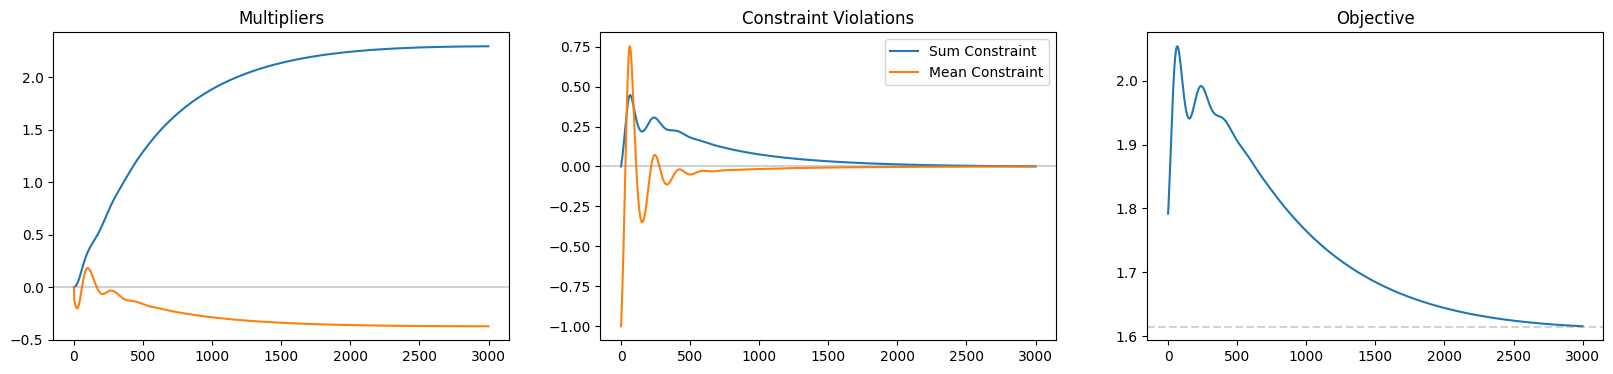

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import cooper

torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MaximumEntropy(cooper.ConstrainedMinimizationProblem):
    def __init__(self, target_mean: float) -> None:
        super().__init__()
        self.target_mean = target_mean

        mean_multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)
        sum_multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)

        self.mean_constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.LagrangianFormulation,
            multiplier=mean_multiplier,
        )
        self.sum_constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.LagrangianFormulation,
            multiplier=sum_multiplier,
        )

        # For simple non-negativity constraints, we use projection

    def compute_cmp_state(self, log_probs: torch.Tensor) -> cooper.CMPState:
        probs = torch.exp(log_probs)
        entropy = -torch.sum(probs * log_probs)

        # Equality constraints for proper normalization and mean constraint
        mean = torch.sum(probs * torch.arange(1, len(probs) + 1, device=DEVICE))

        sum_constraint_violation = cooper.ConstraintState(violation=torch.sum(probs) - 1)
        mean_constraint_violation = cooper.ConstraintState(violation=mean - self.target_mean)

        observed_constraints = {
            self.sum_constraint: sum_constraint_violation,
            self.mean_constraint: mean_constraint_violation,
        }

        # Flip loss sign since we want to *maximize* the entropy
        return cooper.CMPState(loss=-entropy, observed_constraints=observed_constraints)


# Define the problem with the constraints
cmp = MaximumEntropy(target_mean=4.5)

# Define the primal parameters and optimizer
log_probs = torch.nn.Parameter(torch.log(torch.ones(6, device=DEVICE) / 6))
primal_optimizer = torch.optim.SGD([log_probs], lr=3e-2)

# We employ the nuPI algorithm for updating the dual variables
dual_optimizer = cooper.optim.nuPI(cmp.dual_parameters(), lr=1e-2, Kp=10, maximize=True)

cooper_optimizer = cooper.optim.SimultaneousOptimizer(
    primal_optimizers=primal_optimizer, dual_optimizers=dual_optimizer, cmp=cmp
)

state_history = {}
for i in range(3000):
    _, cmp_state, primal_lagrangian_store, _ = cooper_optimizer.roll(compute_cmp_state_kwargs=dict(log_probs=log_probs))

    observed_violations = list(cmp_state.observed_violations())
    observed_multipliers = list(primal_lagrangian_store.observed_multiplier_values())
    state_history[i] = {
        "loss": -cmp_state.loss.item(),
        "multipliers": torch.stack(observed_multipliers).detach(),
        "violation": torch.stack(observed_violations).detach(),
    }


# Theoretical solution
optimal_prob = torch.tensor([0.05435, 0.07877, 0.1142, 0.1654, 0.2398, 0.3475])
optimal_entropy = -torch.sum(optimal_prob * torch.log(optimal_prob))

# Generate plots
iters, loss_hist, multipliers_hist, violation_hist = zip(
    *[(k, v["loss"], v["multipliers"], v["violation"]) for k, v in state_history.items()]
)

_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

ax0.plot(iters, torch.stack(multipliers_hist).squeeze().cpu())
ax0.axhline(0.0, c="gray", alpha=0.35)
ax0.set_title("Multipliers")

ax1.plot(iters, torch.stack(violation_hist).squeeze().cpu(), label=["Sum Constraint", "Mean Constraint"])
ax1.legend()
# Show that defect remains below/at zero
ax1.axhline(0.0, c="gray", alpha=0.35)
ax1.set_title("Constraint Violations")

ax2.plot(iters, loss_hist)
# Show optimal entropy is achieved
ax2.axhline(optimal_entropy, c="gray", alpha=0.35, linestyle="dashed")
ax2.set_title("Objective")

plt.show()